# Analyzing the World Series Games

- batters
- pitchers
- inning by inning

In [46]:
#grab data
import pandas as pd
import numpy as np
import duckdb
from duckdb.typing import *

ws_df = pd.read_csv('../cleaned/pitch_by_pitch.csv')
games_df = pd.read_csv('../cleaned/games.csv')
con = duckdb.connect()

ws_df = con.sql("""
    SELECT *,  game_pk AS game_id,
    CASE
        WHEN game_type = 'W' THEN 'World Series'
        WHEN game_type = 'E' THEN 'Exhibition'
        WHEN game_type = 'S' THEN 'Spring Training'
        WHEN game_type = 'R' THEN 'Regular Season'
        WHEN game_type = 'F' THEN 'Wild Card'
        WHEN game_type = 'D' THEN 'Divisional Series'
        WHEN game_type = 'L' THEN 'League Championship Series'
    END AS game_name
    FROM ws_df
    WHERE game_name = 'World Series'
    ORDER BY game_date
        """).to_df()

ws_df = ws_df.drop(columns=["game_type"])
ws_df.columns

Index(['game_date', 'pitcher', 'batter', 'balls', 'strikes', 'inning',
       'inning_topbot', 'at_bat_number', 'pitch_number', 'events',
       'pitch_type', 'pitch_name', 'release_speed', 'release_pos_x',
       'release_pos_z', 'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'stand', 'p_throws', 'type', 'hit_location', 'bb_type', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated',
       'fielder_2', 'fielder_2.1', 'umpire', 'sv_id', 'vx0', 'vy0', 'vz0',
       'ax', 'ay', 'az', 'sz_top', 'sz_bot', 'hit_distance_sc', 'launch_speed',
       'launch_angle', 'effective_speed', 'release_spin_rate',
       'release_extension', 'game_pk', 'fielder_2.2', 'fielder_2.3',
       'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7',
       'fielder_8', 'fielder_9', 'release_pos_y',
       'estimated

# CHECK OUT THE DATA

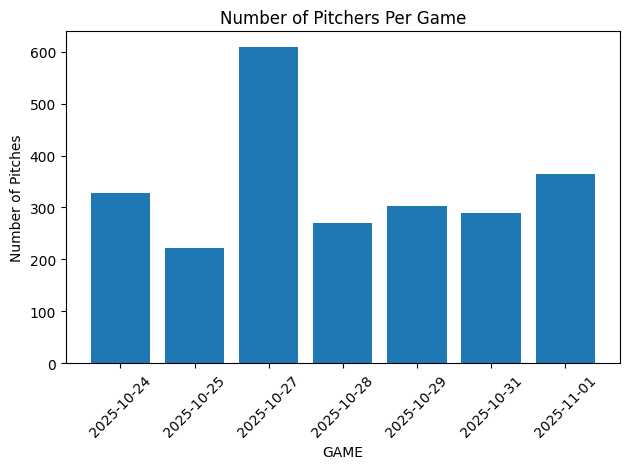

In [47]:
import matplotlib.pyplot as plt

#how many pitches per game
pitches_per_game = con.sql("""
        SELECT count(*) as num_pitches, game_id, game_date
        FROM ws_df
        GROUP BY game_id, game_date
        ORDER BY game_date ASC
        """).to_df()

pitches_per_game

plt.bar(pitches_per_game['game_date'], pitches_per_game['num_pitches'])
plt.xlabel('GAME')
plt.ylabel('Number of Pitches')
plt.title('Number of Pitchers Per Game')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

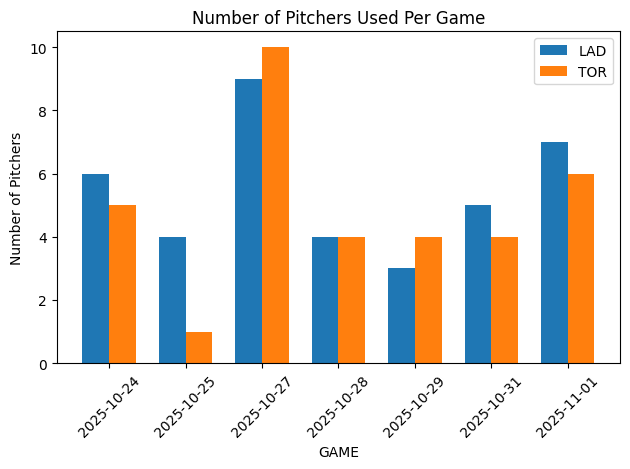

In [65]:
#how many pitchers were used by game by team?
pitchers_per_team = con.sql("""
    SELECT g.game_id, g.game_date,
        CASE 
            WHEN w.inning_topbot = 'Top' THEN g.away_team
            WHEN w.inning_topbot = 'Bot' THEN g.home_team
        END AS pitching_team, count(distinct w.pitcher) AS num_pitchers
    FROM ws_df AS w
    JOIN games_df AS g ON w.game_id = g.game_id
    GROUP BY g.game_id, g.game_date, g.home_team, g.away_team, pitching_team
    ORDER BY g.game_date ASC,
        CASE 
            WHEN pitching_team = g.home_team THEN 0
            ELSE 1
        END
""").to_df()


game_dates = pitchers_per_team['game_date'].unique()
x = np.arange(len(game_dates)) 
width = 0.35 
home_pitchers = pitchers_per_team[pitchers_per_team['pitching_team'] == 
                                  pitchers_per_team['pitching_team'].map(lambda t: t if t in pitchers_per_team['pitching_team'].values else None)]
away_pitchers = pitchers_per_team[pitchers_per_team['pitching_team'] != 
                                  pitchers_per_team['pitching_team'].map(lambda t: t if t in pitchers_per_team['pitching_team'].values else None)]


pivot_df = pitchers_per_team.pivot(index='game_date', columns='pitching_team', values='num_pitchers').fillna(0)
plt.bar(x - width/2, pivot_df[pivot_df.columns[0]], width, label=pivot_df.columns[0])
plt.bar(x + width/2, pivot_df[pivot_df.columns[1]], width, label=pivot_df.columns[1])
plt.xlabel('GAME')
plt.ylabel('Number of Pitchers')
plt.title('Number of Pitchers Used Per Game')
plt.xticks(x, pivot_df.index, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()